In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.000000,0.000350,0.002843,0.002793,0.004750,0.017648,0.008956,-0.009838
2005-02-01,0.005666,-0.003734,-0.005343,0.008802,0.010265,0.013544,0.006425,-0.003549
2005-02-02,0.003756,0.000117,0.002302,0.000884,-0.000668,0.009117,0.003192,0.002612
2005-02-03,-0.014967,-0.001757,-0.000875,-0.008056,-0.002676,0.010767,-0.001758,-0.012077
2005-02-04,0.004748,0.005280,0.014231,0.007231,0.003622,0.017877,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.008723,-0.003464,-0.009217,0.018423,-0.001273,0.012993,-0.005157,0.009863
2024-12-10,-0.005393,-0.001791,-0.004705,-0.016197,-0.008379,0.000855,-0.002896,0.013155
2024-12-11,0.014127,-0.002955,-0.009454,0.000000,0.004041,0.015805,0.007707,0.009247


In [67]:
def calc_rolling_vola(returns, rolling_window=20, resample_period="ME"):
    # Optionally resample the data (if resample_period is provided, e.g., 'M' for monthly)
    if resample_period:
        returns_resampled = returns.resample(resample_period).apply(lambda x: (1 + x).prod() - 1)
    else:
        returns_resampled = returns
    
    # Calculate rolling volatility for each ETF (resampled data if applicable)
    rolling_volatility = returns_resampled.rolling(window=rolling_window).std()
    
    # Add suffix to column names to indicate rolling volatility
    rolling_volatility.columns = [f"{col}_rolling_vol" for col in returns_resampled.columns]
    
    # Combine original returns with rolling volatility for reference
    result = rolling_volatility.dropna()
    
    # Display the result
    return result
volatilities = calc_rolling_vola(returns)
volatilities['Aggregate'] = volatilities.mean(axis=1).dropna()
volatilities

,Japan_rolling_vol,T-Bills_7_10_rolling_vol,T-Bills_20_rolling_vol,APACxJapan_rolling_vol,Europe_rolling_vol,LatAm_rolling_vol,US_rolling_vol,Gold_rolling_vol,Aggregate
Exchange Date,,,,,,,,,
2006-08-31,0.040317,0.013372,0.025561,0.037181,0.025938,0.075820,0.020373,0.045072,0.035454
2006-09-30,0.040634,0.013529,0.025810,0.037398,0.025907,0.075915,0.020689,0.046940,0.035853
2006-10-31,0.040626,0.013062,0.025503,0.039512,0.025616,0.073344,0.021249,0.046862,0.035722
2006-11-30,0.039513,0.013153,0.025771,0.038417,0.024433,0.068527,0.020093,0.047638,0.034693
2006-12-31,0.038618,0.012818,0.025679,0.038518,0.023238,0.067494,0.019057,0.048435,0.034232
...,...,...,...,...,...,...,...,...,...
2024-08-31,0.036181,0.024804,0.049821,0.047620,0.044682,0.060209,0.037044,0.039367,0.042466
2024-09-30,0.033227,0.023554,0.046662,0.045308,0.040379,0.054886,0.035671,0.039027,0.039839
2024-10-31,0.033408,0.023705,0.047041,0.043940,0.042532,0.053901,0.034832,0.035760,0.039390


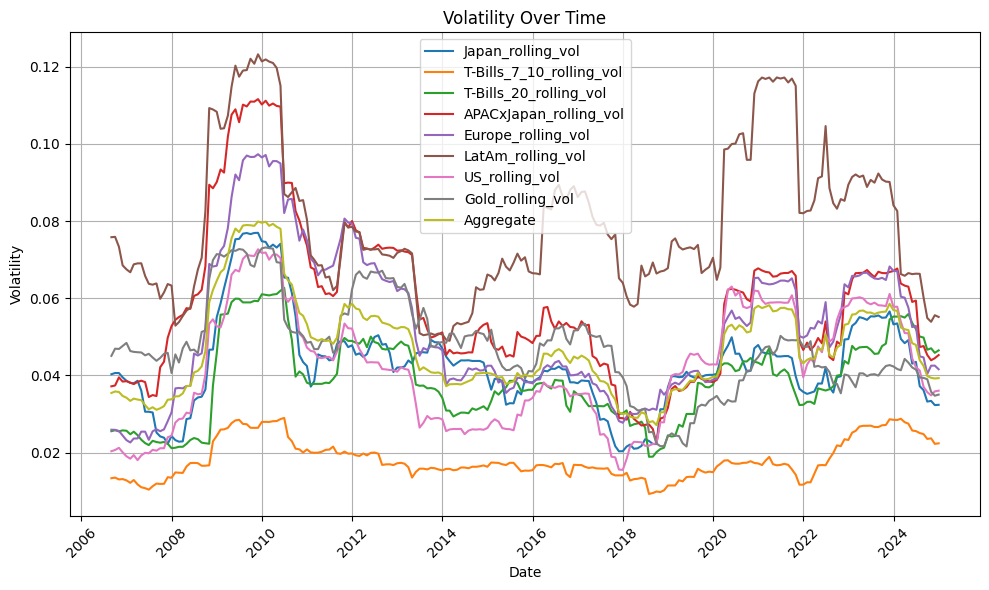

In [68]:
plt.figure(figsize=(10, 6))
for column in volatilities.columns:
    plt.plot(volatilities.index, volatilities[column], label=column)
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [77]:
high_threshold = np.percentile(volatilities['Aggregate'], 67)
med_threshold = np.percentile(volatilities['Aggregate'], 33)

# Classify periods into 3 regimes
def classify_volatility(vol):
    if vol >= high_threshold:
        return 'High'
    elif vol >= med_threshold:
        return 'Medium'
    else:
        return 'Low'

volatilities['Volatility_Regime'] = volatilities['Aggregate'].apply(classify_volatility)
volatilities

,Japan_rolling_vol,T-Bills_7_10_rolling_vol,T-Bills_20_rolling_vol,APACxJapan_rolling_vol,Europe_rolling_vol,LatAm_rolling_vol,US_rolling_vol,Gold_rolling_vol,Aggregate,Volatility_Regime
Exchange Date,,,,,,,,,,
2006-08-31,0.040317,0.013372,0.025561,0.037181,0.025938,0.075820,0.020373,0.045072,0.035454,Low
2006-09-30,0.040634,0.013529,0.025810,0.037398,0.025907,0.075915,0.020689,0.046940,0.035853,Low
2006-10-31,0.040626,0.013062,0.025503,0.039512,0.025616,0.073344,0.021249,0.046862,0.035722,Low
2006-11-30,0.039513,0.013153,0.025771,0.038417,0.024433,0.068527,0.020093,0.047638,0.034693,Low
2006-12-31,0.038618,0.012818,0.025679,0.038518,0.023238,0.067494,0.019057,0.048435,0.034232,Low
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.036181,0.024804,0.049821,0.047620,0.044682,0.060209,0.037044,0.039367,0.042466,Medium
2024-09-30,0.033227,0.023554,0.046662,0.045308,0.040379,0.054886,0.035671,0.039027,0.039839,Low
2024-10-31,0.033408,0.023705,0.047041,0.043940,0.042532,0.053901,0.034832,0.035760,0.039390,Low


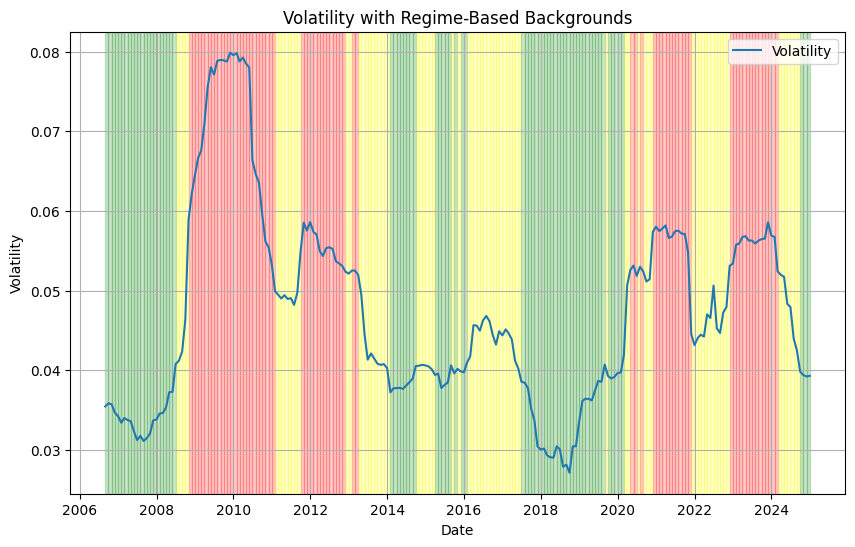

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(volatilities.index, volatilities['Aggregate'], label='Volatility')

# Add colored background based on volatility regime
for i in range(len(volatilities) - 1):  # Loop over rows, excluding the last row
    if volatilities['Volatility_Regime'].iloc[i] == 'Low':
        plt.axvspan(volatilities.index[i], volatilities.index[i + 1],
                    color='green', alpha=0.2)
    elif volatilities['Volatility_Regime'].iloc[i] == 'Medium':
        plt.axvspan(volatilities.index[i], volatilities.index[i + 1],
                    color='yellow', alpha=0.2)
    elif volatilities['Volatility_Regime'].iloc[i] == 'High':
        plt.axvspan(volatilities.index[i], volatilities.index[i + 1],
                    color='red', alpha=0.2)

# Add labels and legend
plt.title('Volatility with Regime-Based Backgrounds')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [79]:
volatility_switches = (volatilities[volatilities['Volatility_Regime'].shift() != volatilities['Volatility_Regime']]).index

print(f'Volatility regime switches:\n {volatility_switches}')

Volatility regime switches:
 DatetimeIndex(['2006-08-31', '2008-06-30', '2008-10-31', '2011-01-31',
               '2011-09-30', '2012-11-30', '2013-01-31', '2013-03-31',
               '2014-01-31', '2014-09-30', '2015-03-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2016-01-31',
               '2017-06-30', '2019-08-31', '2019-09-30', '2020-02-29',
               '2020-04-30', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-11-30', '2021-11-30', '2022-11-30', '2024-02-29',
               '2024-09-30'],
              dtype='datetime64[ns]', name='Exchange Date', freq=None)
